pip install tensorflow  


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import numpy as np
import imageio
import math
import IPython.display
import PIL
import os

K.set_floatx('float16')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [39]:
patch_size = 64
mini_batch_size = 3
percent_used_for_validation = 0.1
output_kernel_size = 17
enable_albedo_div = False
mode = "kpcn"
checkpoint_path = "training_" + mode + "/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [37]:
@tf.function
def kernel_apply(input):
    halfsize = output_kernel_size//2
    w = input[:,:,:,3:]
#     w = tf.math.exp(input[:,:,:,3:])
#     y = tf.reduce_sum(tf.abs(w), axis=3)
#     y = tf.reduce_sum(w, axis=3) + 0.05
#     y = tf.reshape(y, (-1, y.shape[1], y.shape[2], 1))
#     w = tf.math.divide_no_nan(w, y)
    w = tf.stack([w, w, w], axis=3)
    z = input[:,:,:,:3]*0

    for i in range(output_kernel_size):
        for j in range(output_kernel_size):
            padded_input = tf.pad(input[:,:,:,:3], tf.constant([[0, 0], [j, output_kernel_size - j - 1], [i, output_kernel_size - i - 1], [0, 0]]), "CONSTANT")
            padded_input = padded_input[:,halfsize:-halfsize,halfsize:-halfsize]
            z = z + padded_input * w[:,:,:,:,i*3 + j]

    return z


class KernelApply2D(tf.keras.layers.Layer):
    def __init__(self):
        super(KernelApply2D, self).__init__()

    def call(self, input):
        return kernel_apply(input)

# if mode == "kpcn":
#     pass
# output_kernel_size = 3
# layer = KernelApply2D()
# # xpatch = y_patches[405][:,:,:3]
# # print(xpatch.dtype)
# xpatch = tf.ones((32,32,3), dtype=tf.float16) * 255.0
# xpatch = tf.pad(xpatch, [[16, 16], [16, 16], [0, 0]], "CONSTANT")
# x = xpatch[:,:,0]
# x = tf.repeat(x, 3)

# x = tf.reshape(x, (1, 64, 64, 3))
# w = tf.constant([1.0, 2.0, 1.0, 0.0, 0.0, 0.0, -1.0, -2.0, -1.0], dtype=tf.float16)
# w = tf.reshape(w, (1, 1, 1, 9))
# w = tf.tile(w, tf.constant([1, 64, 64, 1]))

# x = tf.concat([x, w], axis=3)
# predicted = layer(x)[0]

# imshow(xpatch)
# z = imshow(predicted)
# output = layer(x)
# output[0,0,0]

In [4]:
class ChannelCroppingLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(ChannelCroppingLayer, self).__init__()

    def call(self, input):
        return input[:,:,:,:3]


In [30]:
def make_3_channels(image):
    if image.ndim == 2: image = np.dstack((image, image, image))
    if image.shape[2] == 1: 
        image = np.reshape(image, (64, 64))
        image = np.dstack((image, image, image))
    image = image[:,:,:3]
    return image

# somewhat based off the getVarianceMap function from https://github.com/Nidjo123/kpcn
def preprocess_variance(variance):
    variance = variance.max(axis=2)
    variance = np.minimum(variance**(1.0/2.2), 1.0)
    variance = variance / variance.max()
    return variance
    
def preprocess_color(color, albedo, epsilon=0.1):
    return color.astype(np.float32) / (albedo + epsilon)

def postprocess_color(color, albedo, epsilon=0.1):
    return color * (albedo + epsilon)

def preprocess_color_variance(variance, albedo, epsilon=0.1):
    variance = variance / (albedo + epsilon)**2
    return preprocess_variance(variance)
    
def calculate_gradient(image):
    y, x, c = image.shape
    dx = image[:, 1:, :] - image[:, :x-1, :]
    dy = image[1:, :, :] - image[:y-1, :, :]
    dx = np.append(dx, np.zeros([y, 1, c]), axis=1)
    dy = np.append(dy, np.zeros([1, x, c]), axis=0)
    grad = np.dstack((dx, dy))
    return grad

def load_highspp(folder_path):
    albedo = make_3_channels(imageio.imread(folder_path + "/albedo.png").astype(np.float32))
    color = make_3_channels(imageio.imread(folder_path + "/final.png").astype(np.float32))
    if enable_albedo_div:
        color = preprocess_color(color, albedo)
    
    combined = np.dstack((color, albedo))
    combined = combined.astype(np.float16)
    assert not np.any(np.isnan(combined))
    return combined

def load_lowspp(folder_path):
    print("loading " + folder_path)

    # albedo buffers
    albedo = make_3_channels(imageio.imread(folder_path + "/albedo.png").astype(np.float32))
    albedo_variance = make_3_channels(imageio.imread(folder_path + "/albedoVariance.png").astype(np.float32))
    albedo_variance = preprocess_variance(albedo_variance)
    albedo_gradient = calculate_gradient(albedo)

    # color buffers
    color = make_3_channels(imageio.imread(folder_path + "/final.png").astype(np.float32))
    if enable_albedo_div:
        color = preprocess_color(color, albedo)
    color_variance = make_3_channels(imageio.imread(folder_path + "/colorVariance.png").astype(np.float32))
    if enable_albedo_div:
        color_variance = preprocess_color_variance(color_variance, albedo)
    else:
        color_variance = preprocess_variance(color_variance)

    color_gradient = calculate_gradient(color)

    # depth buffers
    depth = imageio.imread(folder_path + "/depth.png").astype(np.float32)
    depth = depth.reshape((depth.shape[0], depth.shape[1], 1))
    depth_variance = make_3_channels(imageio.imread(folder_path + "/depthVariance.png").astype(np.float32))
    depth_variance = preprocess_variance(depth_variance)
    # depth_gradient = calculate_gradient(depth)

    # normal buffers
    normal = make_3_channels(imageio.imread(folder_path + "/normal.png").astype(np.float32))
    normal_variance = make_3_channels(imageio.imread(folder_path + "/normalVariance.png").astype(np.float32))
    normal_variance = preprocess_variance(normal_variance)
    # normal_gradient = calculate_gradient(normal)
    
    normal_variance = normal_variance.reshape((normal_variance.shape[0], normal_variance.shape[1], 1))
    color_variance = color_variance.reshape((color_variance.shape[0], color_variance.shape[1], 1))
    albedo_variance = albedo_variance.reshape((albedo_variance.shape[0], albedo_variance.shape[1], 1))
    depth_variance = depth_variance.reshape((depth_variance.shape[0], depth_variance.shape[1], 1))

    
#     chans = (color, albedo, color_gradient, albedo_gradient, depth, normal, color_variance, albedo_variance, depth_variance, normal_variance)
#     names = []
#     for x in "color, albedo, color_gradient, albedo_gradient, depth, normal, color_variance, albedo_variance, depth_variance, normal_variance".split(", "):
#         names.append(x)
#     for i in range(len((chans))):
#         print("channel " + names[i] + " shape: " + str(chans[i].shape))
    
    combined = np.dstack((color, albedo, color_gradient, albedo_gradient, depth, normal, color_variance, albedo_variance, depth_variance, normal_variance))
    combined = combined.astype(np.float16)
    assert not np.any(np.isnan(combined))
    return combined

In [6]:
def imshow(data):
    data = np.clip(data, 0.0, 255.0).astype(np.uint8)
    pil_img = PIL.Image.fromarray(data, 'RGB')
    display(pil_img)
    return pil_img

def imshow_pp(data):
    if enable_albedo_div:
        data = postprocess_color(data[:,:,:3], data[:,:,3:])
    return imshow(data[:,:,:3])


In [7]:
# split full res image into patch_size * patch_size images
def get_patches(image):
    x_patches = math.floor(image.shape[0]/patch_size)
    y_patches = math.floor(image.shape[1]/patch_size)
    patches = []
    for x in range(x_patches):
        for y in range(y_patches):
            xstart = x * patch_size
            xend = xstart + patch_size
            ystart = y * patch_size
            yend = ystart + patch_size
            temp = image[xstart:xend, ystart:yend, :]
            patches.append(temp)
        patches.append(image[xstart:xend, image.shape[1]-patch_size:, :])
    return patches

In [8]:
# note to self: use this https://www.tensorflow.org/api_docs/python/tf/data/experimental/sample_from_datasets
def load_x_y_patches():
    x_patches = []
    y_patches = []
    y_patches_with_albedo = []
    orig = next(os.walk('./pngs'))[1]
    folders = [x[0:x.rindex('16')] for x in orig if '16' in x]

    for x in folders:
        low_spp = load_lowspp('./pngs/' + x + '16')
        high_spp = load_highspp('./pngs/' + x + '4096')
        temp_x_patches = get_patches(low_spp)
        temp_y_patches = get_patches(high_spp)

        for i in range(len(temp_x_patches)):
            x_patches.append(temp_x_patches[i])
            y_patches.append(temp_y_patches[i][:,:,:3])
            y_patches_with_albedo.append(temp_y_patches[i])

    return x_patches, y_patches, y_patches_with_albedo


In [31]:
x_patches, y_patches, y_patches_with_albedo = load_x_y_patches()

loading ./pngs/bathroom16
loading ./pngs/bathroom2-16
loading ./pngs/bedroom-16
loading ./pngs/car-16
loading ./pngs/car2-16
loading ./pngs/classroom-16
loading ./pngs/coffee-16
loading ./pngs/cornell-box-16
loading ./pngs/curly-hair-16
loading ./pngs/dining-room-16
loading ./pngs/dragon-16
loading ./pngs/furball-16
loading ./pngs/hair-curl-16
loading ./pngs/house-16
loading ./pngs/kitchen-16
loading ./pngs/lamp-16
loading ./pngs/living-room-16
loading ./pngs/living-room-2-16
loading ./pngs/living-room-3-16
loading ./pngs/material-testball-16
loading ./pngs/spaceship-16
loading ./pngs/staircase-16
loading ./pngs/staircase2-16
loading ./pngs/straight-hair-16
loading ./pngs/teapot-16
loading ./pngs/teapot-full-16
loading ./pngs/veach-ajar-16
loading ./pngs/veach-mis-16


In [10]:

# load_lowspp("./pngs/bathroom16")
# print("x patches shape: " + str(x_patches[0].shape))
# pn = 405
# print("color div albedo")
# imshow(x_patches[pn][:,:,:3])
# print("color")
# imshow_pp(x_patches[pn][:,:,:6])
# print("albedo")
# imshow(x_patches[pn][:,:,3:6])
# print("color x gradient")
# imshow(x_patches[pn][:,:,6:9])
# print("color y gradient")
# imshow(x_patches[pn][:,:,9:12])
# print("albedo x gradient")
# imshow(x_patches[pn][:,:,12:15])
# print("albedo y gradient")
# imshow(x_patches[pn][:,:,15:18])
# print("depth")
# imshow(make_3_channels(x_patches[pn][:,:,18:19]))
# print("normal")
# imshow(x_patches[pn][:,:,19:22])
# print("color variance")
# imshow(make_3_channels(x_patches[pn][:,:,22:23]))
# print("albedo variance")
# imshow(make_3_channels(x_patches[pn][:,:,23:24]))
# print("depth variance")
# imshow(make_3_channels(x_patches[pn][:,:,24:25]))
# print("normal variance")
# imshow(make_3_channels(x_patches[pn][:,:,25:26]))

In [40]:
def make_nn(input_channels):
    #basic model parameters
    L = 9
    kernel_size = 5
    hidden_channels = 100
    in_between_layers = L - 2

    # add layers
    noisy_input = keras.Input(shape=(patch_size, patch_size, input_channels))
    cropped_noisy_input = ChannelCroppingLayer()(noisy_input)
    x = noisy_input
    for i in range(in_between_layers):
        x = layers.ZeroPadding2D(padding=(2, 2))(x)
        x = layers.Conv2D(hidden_channels, kernel_size=kernel_size, kernel_initializer="glorot_uniform", strides=1, activation="relu")(x)

    x = layers.ZeroPadding2D(padding=(2, 2))(x)
    outputs = output_kernel_size**2 if mode == "kpcn" else 3
    x = layers.Conv2D(outputs, kernel_size=kernel_size, kernel_initializer="glorot_uniform", strides=1, activation="softmax")(x)
    x = layers.concatenate([cropped_noisy_input, x])
    
    x = KernelApply2D()(x)
    # compile model
    model = keras.Model(inputs=[noisy_input], outputs=[x])
    opt = keras.optimizers.Adam(learning_rate=10e-5)
    model.compile(loss="mean_absolute_error", optimizer=opt, metrics=['mean_absolute_error'])

    return model

model = make_nn(x_patches[0].shape[2])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 26)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_48 (ZeroPadding2 (None, 68, 68, 26)   0           input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 64, 64, 100)  65100       zero_padding2d_48[0][0]          
__________________________________________________________________________________________________
zero_padding2d_49 (ZeroPadding2 (None, 68, 68, 100)  0           conv2d_48[0][0]                  
____________________________________________________________________________________________

In [12]:
def create_tf_dataset(x_patches, y_patches):
    validate_amount = math.floor(len(x_patches) * percent_used_for_validation)
    rec_count = len(x_patches)
    ds = tf.data.Dataset.from_tensor_slices((x_patches, y_patches))
    ds = ds.shuffle(buffer_size=400, reshuffle_each_iteration=True)
    train = ds.skip(validate_amount).batch(mini_batch_size)
    validate = ds.take(validate_amount).batch(mini_batch_size)
    return train, validate

In [13]:
# train, validate = prepare_training_data()
train, validate = create_tf_dataset(x_patches, y_patches)

In [14]:
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# model.load_weights(latest)
# model

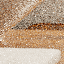

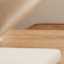

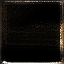

In [41]:
def display_and_save_image(patch_number=405, epoch=-1):
    xpatch = x_patches[patch_number]
    xpatchcolor = xpatch[:,:,:6]
    gt = y_patches_with_albedo[patch_number]
    predicted = model.predict(xpatch.reshape((1, xpatch.shape[0], xpatch.shape[1], xpatch.shape[2])))[0]
    predicted = np.dstack((predicted, gt[:,:,3:]))
    if enable_albedo_div:
        imshow_pp(xpatchcolor).save(checkpoint_dir + '/epoch_' + str(epoch) + '_xpatch.png')
        imshow_pp(gt).save(checkpoint_dir + '/epoch_' + str(epoch) + '_gt.png')
        imshow(gt[:,:,:3]).save(checkpoint_dir + '/epoch_' + str(epoch) + '_gt_divalbedo.png')
        imshow_pp(predicted).save(checkpoint_dir + '/epoch_' + str(epoch) + '_prediction.png')
        imshow(predicted[:,:,:3]).save(checkpoint_dir + '/epoch_' + str(epoch) + '_prediction_divalbedo.png')
    else:
        imshow(xpatchcolor[:,:,:3]).save(checkpoint_dir + '/epoch_' + str(epoch) + '_xpatch.png')
        imshow(gt[:,:,:3]).save(checkpoint_dir + '/epoch_' + str(epoch) + '_gt.png')
        imshow_pp(predicted[:,:,:3]).save(checkpoint_dir + '/epoch_' + str(epoch) + '_prediction.png')

        
class DisplayImageCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(DisplayImageCallback, self).__init__()
    
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 != 0:
            return

        # if predicting final output
        display_and_save_image(405, epoch)

display_and_save_image()

In [ ]:
print("Fit model on training data")
image_cb = DisplayImageCallback()
history_cb = tf.keras.callbacks.CSVLogger(checkpoint_dir + '/log.csv', separator=",", append=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(
    train,
    validation_data=validate,
    epochs=10000,
    callbacks=[cp_callback, history_cb, image_cb]
)

Fit model on training data
Epoch 1/10000
  81/2035 [>.............................] - ETA: 4:31 - loss: nan - mean_absolute_error: nan

In [ ]:
# print(model.layers[1].get_weights()[0])
# model.predict(xpatch)

In [ ]:
newpatch = x_patches[1350] #np.reshape(x_patches[1350], (1, 64, 64, 40))
newpatch = np.stack((newpatch, newpatch, newpatch, newpatch, newpatch), axis=0)
newpatch.shape

In [ ]:
pn = 405
xpatch = x_patches[pn]
xpatch = np.stack((xpatch, xpatch, xpatch, xpatch, xpatch), axis=0)
prediction = model.predict(xpatch)
prediction
xpatch

In [ ]:
# imshow((prediction[0] * 255.0).astype(np.uint8))
prediction